In [2]:
# Use if you run the notebook on Google colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
!pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.7 MB/s eta 0:00:00


# 5: Logistic Regression


## Imports

In [4]:
import os
import sys

sys.path.append("/content/drive/MyDrive/50603/code")
os.chdir('/content/drive/MyDrive/50603')

import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import Image, HTML, display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

## Logistic regression [[video](https://youtu.be/56L5z_t22qE)]

### Logistic regression intuition

- A linear model for **classification**.
- Similar to linear regression, it learns weights associated with each feature and the bias.
- It applies a **threshold** on the raw output to decide whether the class is positive or negative.
- In this lecture we will focus on the following aspects of logistic regression.  
    - `predict`, `predict_proba`
    - how to use learned coefficients to interpret the model

### Motivating example

- Consider the problem of **predicting *sentiment*** expressed in **movie *reviews***.

#### Training data for the motivating example


<blockquote>
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p>
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p>
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *flawless*, *boring*)


#### Learned coefficients associated with all features

- Suppose our vocabulary contains only the following 7 words.
- A linear classifier learns **weights** or **coefficients** associated with the features (words in this example).  
- Let's ignore bias for a bit.


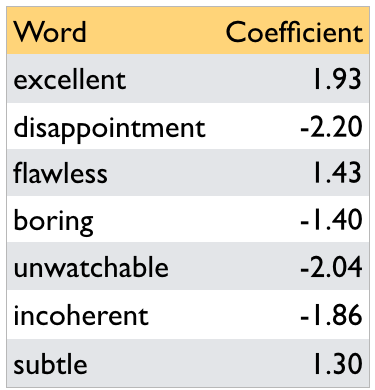

In [5]:
p = 'img/words_coeff.png'
display(Image(filename=p, width=250))

#### Predicting with learned weights
- Use these learned coefficients to make predictions. For example, consider the following review $x_i$.
<blockquote>
It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>.
</blockquote>
- Feature vector for $x_i$: [1, 0, 1, 1, 0, 0, 0]

- $score(x_i) = $ coefficient(*boring*) $\times 1$ + coefficient(*excellent*) $\times 1$ + coefficient(*flawless*) $\times 1$ = $-1.40 + 1.93 + 1.43 = 1.96$

- $1.96 > 0$ so predict the review as positive 👍.

Weighted sum of the input features = 1.960 y_hat = pos


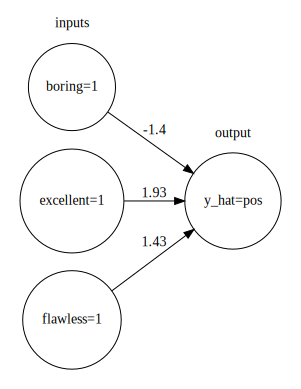

In [7]:
x = ["boring=1", "excellent=1", "flawless=1"]
w = [-1.40, 1.93, 1.43]
display(plot_logistic_regression(x, w))

- So the prediction is based on the weighted sum of the input features.
- Some feature are pulling the prediction towards positive sentiment and some are pulling it towards negative sentiment.
- If the coefficient of _boring_ had a bigger magnitude or _excellent_ and _flawless_ had smaller magnitudes, we would have predicted "neg".   

In [8]:
def f(w_0):
    x = ["boring=1", "excellent=1", "flawless=1"]
    w = [-1.40, 1.93, 1.43]
    w[0] = w_0
    print(w)
    display(plot_logistic_regression(x, w))

In [9]:
interactive(
    f,
    w_0=widgets.FloatSlider(min=-4.40, max=2.40, step=0.5, value=-1.40),
)

interactive(children=(FloatSlider(value=-1.4, description='w_0', max=2.4, min=-4.4, step=0.5), Output()), _dom…

In our case, for values for the coefficient of _boring_ < -3.36, the prediction would be negative.

A linear model learns these coefficients or weights from the training data!

So a linear classifier is a linear function of the input `X`, followed by a threshold.

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots + w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

$$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         -1, & \text{if } z < r
\end{cases}$$

#### Components of a linear classifier

1. input features ($x_1, \dots, x_d$)
2. coefficients (weights) ($w_1, \dots, w_d$)
3. bias ($b$ or $w_0$) (can be used to offset your hyperplane)
4. threshold ($r$)

In our example before, we assumed $r=0$ and $b=0$.

### Logistic regression on the cities data

In [10]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"]).values, train_df["country"].values
X_test, y_test = test_df.drop(columns=["country"]).values, test_df["country"].values

cols = train_df.drop(columns=["country"]).columns
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


Now let's try `LogisticRegression`

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
scores = cross_validate(lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.016926,0.001209,0.852941,0.827068
1,0.005946,0.000937,0.823529,0.827068
2,0.005316,0.000961,0.696970,0.858209
3,0.005558,0.000939,0.787879,0.843284
4,0.009412,0.000986,0.939394,0.805970


Logistic regression seems to be doing well. But note that there is a lot of variation in the scores.

### Accessing learned parameters

- Recall that logistic regression learns the weights $w$ and bias or intercept $b$.

- How to access these weights?
    - Similar to `Ridge`, we can access the weights and intercept using `coef_` and `intercept_` attribute of the `LogisticRegression` object, respectively.

In [12]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))  # these are the learned weights
print("Model intercept: %s" % (lr.intercept_))  # this is the bias term
data = {"features": cols, "coefficients": lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[-0.04108378 -0.33683087]]
Model intercept: [10.886759]


,features,coefficients
0,longitude,-0.041084
1,latitude,-0.336831


- Both negative weights
- The weight of latitude is larger in magnitude.
- This makes sense because Canada as a country lies above the USA and so we expect latitude values to contribute more to a prediction than longitude.

### Prediction with learned parameters

Let's predict target of a test example.

In [13]:
example = X_test[0, :]
example

array([-64.8001,  46.098 ])

In [14]:
y_test[0]  # The country for this example

'Canada'

#### Raw scores

- Calculate the raw score as: `y_hat = np.dot(w, x) + b`

In [15]:
(
    np.dot(
        example,
        lr.coef_.reshape(2,),
    )
    + lr.intercept_
)

array([-1.97823755])

- Apply the threshold to the raw score.
- Since the prediction is < 0, predict "negative".
- What is a "negative" class in our context?
- With logistic regression, the model randomly assigns one of the classes as a positive class and the other as negative.
    - Usually it would **alphabetically order the target and pick the first one as negative and second one as the positive class**.

- The `classes_` attribute tells us which class is considered negative and which one is considered positive. - In this case, Canada is the negative class and USA is a positive class.

In [16]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- So based on the negative score above (-1.978), we would predict Canada.
- Let's check the prediction given by the model.

In [17]:
lr.predict([example])

array(['Canada'], dtype=object)

Great! The predictions match! We exactly know how the model is making predictions.

### Decision boundary of logistic regression

- The decision boundary of logistic regression is a **hyperplane** dividing the feature space in half.

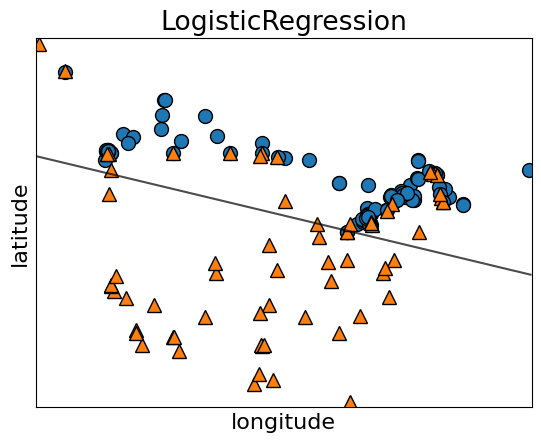

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
mglearn.plots.plot_2d_separator(lr, X_train, fill=False, eps=0.5, alpha=0.7)
plt.title(lr.__class__.__name__)
plt.xlabel("longitude")
plt.ylabel("latitude");

- For $d=2$, the decision boundary is a line (1-dimensional)
- For $d=3$, the decision boundary is a plane (2-dimensional)
- For $d\gt 3$, the decision boundary is a $d-1$-dimensional hyperplane

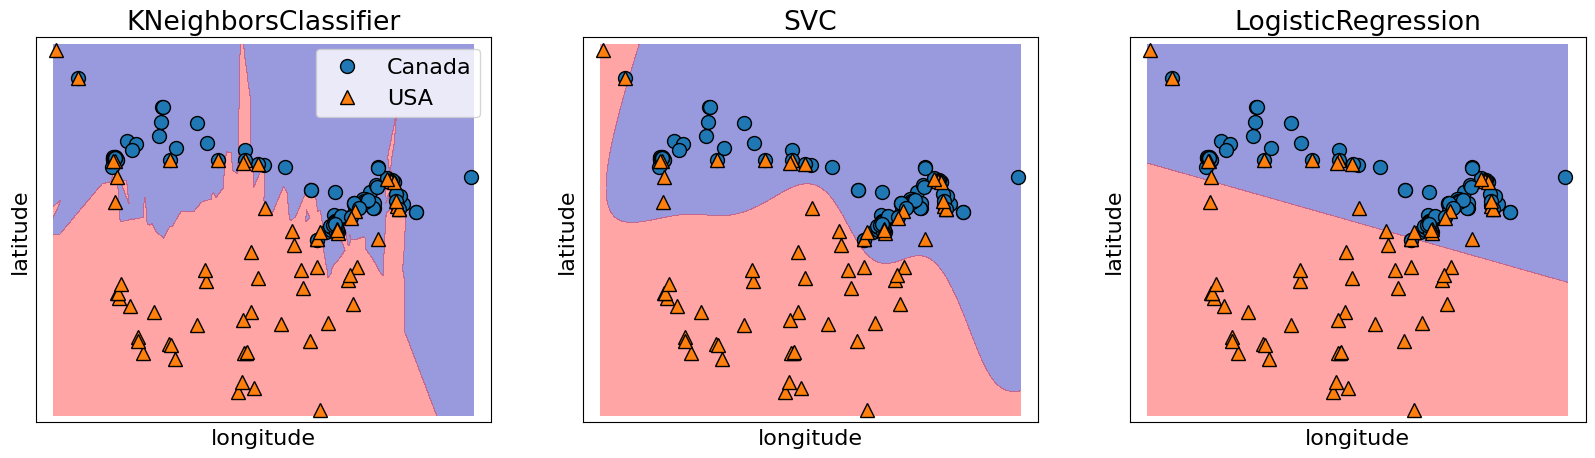

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for model, ax in zip(
    [KNeighborsClassifier(), SVC(gamma=0.01), LogisticRegression()], axes
):
    clf = model.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(
        clf, X_train, fill=True, eps=0.5, ax=ax, alpha=0.4
    )
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
axes[0].legend();

- Notice a linear decision boundary (a line in our case).
- Compare it with  KNN or SVM RBF decision boundaries.

### Main hyperparameter of logistic regression

- `C` is the main hyperparameter which controls the fundamental trade-off.
- We won't really talk about the interpretation of this hyperparameter right now.
- At a high level, the interpretation is similar to `C` of SVM RBF
    - smaller `C` $\rightarrow$ might lead to underfitting
    - bigger `C` $\rightarrow$ might lead to overfitting

In [20]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C)
    scores = cross_validate(lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.664707,0.658645
1,0.0010,0.784424,0.790731
2,0.0100,0.827842,0.826203
3,0.1000,0.832320,0.820143
4,1.0000,0.832320,0.820143
5,10.0000,0.832320,0.820143
6,100.0000,0.832320,0.820143
7,1000.0000,0.832320,0.820143
8,10000.0000,0.832320,0.820143
9,100000.0000,0.832320,0.820143


<br><br><br><br>

## Predicting probability scores [[video](https://youtu.be/_OAK5KiGLg0)]

### `predict_proba`

- So far in the context of classification problems, we focused on getting "hard" predictions.
- Very often it's useful to know "soft" predictions, i.e., how confident the model is with a given prediction.  
- For most of the `scikit-learn` classification models we can access this **confidence score** or **probability score** using a method called `predict_proba`.  

Let's look at probability scores of logistic regression model for our test example.

In [21]:
example

array([-64.8001,  46.098 ])

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict([example])  # hard prediction

array(['Canada'], dtype=object)

In [23]:
lr.predict_proba([example])  # soft prediction

array([[0.87849316, 0.12150684]])

- The output of `predict_proba` is the probability of each class.
- In binary classification, we get probabilities associated with both classes (even though this information is redundant).
- The first entry is the estimated probability of the first class and the second entry is the estimated probability of the second class from `model.classes_`.

In [24]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- Because it's a probability, the sum of the entries for both classes should always sum to 1.
- Since the probabilities for the two classes sum to 1, exactly one of the classes will have a score >=0.5, which is going to be our predicted class.  

#### How does logistic regression calculate these probabilities?

- The weighted sum $w_1x_1 + \dots + w_dx_d + b$ gives us "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive (or 0), predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".

- You can also have "soft predictions", aka **predicted probabilities**.
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the **sigmoid**.

#### The sigmoid function
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$ using the following formula, where $x$ is the raw model output.
$$\frac{1}{1+e^{-x}}$$
- Then we can interpret the output as probabilities.

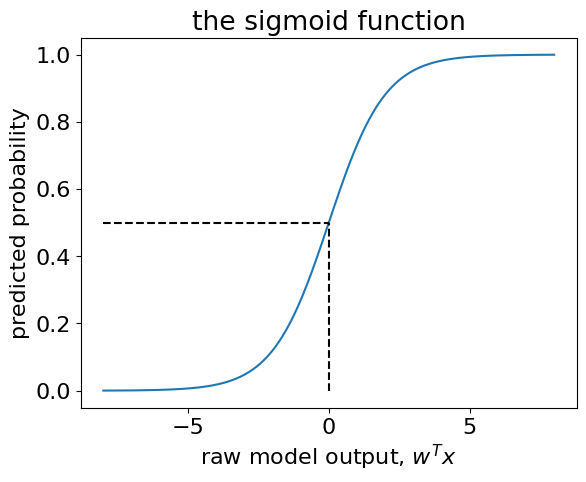

In [25]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

- Recall our hard predictions that check the sign of $w^Tx$, or, in other words, whether or not it is $\geq 0$.
  - The threshold $w^Tx=0$ corresponds to $p=0.5$.
  - In other words, if our predicted probability is $\geq 0.5$ then our hard prediction is $+1$.

Let's get the probability score by calling sigmoid on the raw model output for our test example.

In [26]:
sigmoid(
    np.dot(
        example,
        lr.coef_.reshape(2,),
    )
    + lr.intercept_
)

array([0.12150684])

This is the probability score of the positive class, which is USA.

In [27]:
lr.predict_proba([example])

array([[0.87849316, 0.12150684]])

With `predict_proba`, we get the same probability score for USA!!

- Let's visualize probability scores for some examples.

In [28]:
data_dict = {
    "y": y_train[:12],
    "y_hat": lr.predict(X_train[:12]).tolist(),
    "probabilities": lr.predict_proba(X_train[:12]).tolist(),
}

In [29]:
pd.DataFrame(data_dict)

,y,y_hat,probabilities
0,Canada,Canada,"[0.7046136400143153, 0.29538635998568474]"
1,Canada,Canada,"[0.563022417465155, 0.4369775825348449]"
2,Canada,Canada,"[0.8389756947416379, 0.16102430525836212]"
3,Canada,Canada,"[0.7964215270662828, 0.2035784729337172]"
4,Canada,Canada,"[0.9010852321946805, 0.09891476780531953]"
5,Canada,Canada,"[0.7752884548630525, 0.2247115451369474]"
6,USA,USA,"[0.030739733331868968, 0.969260266668131]"
7,Canada,Canada,"[0.6880359361853491, 0.3119640638146509]"
8,Canada,Canada,"[0.7891381897690063, 0.21086181023099373]"
9,USA,USA,"[0.006546893270012344, 0.9934531067299877]"


The actual `y` and `y_hat` match in most of the cases but in some cases the model is more confident about the prediction than others.

#### Least confident cases

Let's examine some cases where the model is least confident about the prediction.

In [30]:
least_confident_X = X_train[[127, 141]]
least_confident_X

array([[ -79.7599,   43.6858],
       [-123.078 ,   48.9854]])

In [31]:
least_confident_y = y_train[[127, 141]]
least_confident_y

array(['Canada', 'USA'], dtype=object)

In [32]:
probs = lr.predict_proba(least_confident_X)

data_dict = {
    "y": least_confident_y,
    "y_hat": lr.predict(least_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,Canada,Canada,0.634397,0.365603
1,USA,Canada,0.635648,0.364352


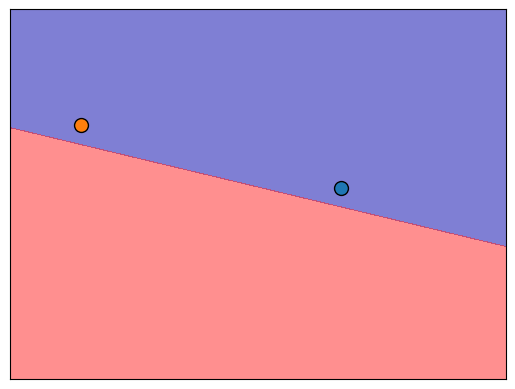

In [33]:
mglearn.discrete_scatter(
    least_confident_X[:, 0],
    least_confident_X[:, 1],
    least_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train, fill=True, eps=0.5, alpha=0.5)

The points are close to the decision boundary which makes sense.

#### Most confident cases

Let's examine some cases where the model is most confident about the prediction.

In [34]:
most_confident_X = X_train[[37, 4]]
most_confident_X

array([[-110.9748,   32.2229],
       [ -67.9245,   47.1652]])

In [35]:
most_confident_y = y_train[[37, 165]]
most_confident_y

array(['USA', 'Canada'], dtype=object)

In [36]:
probs = lr.predict_proba(most_confident_X)

data_dict = {
    "y": most_confident_y,
    "y_hat": lr.predict(most_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,USA,USA,0.010027,0.989973
1,Canada,Canada,0.901085,0.098915


In [37]:
most_confident_X

array([[-110.9748,   32.2229],
       [ -67.9245,   47.1652]])

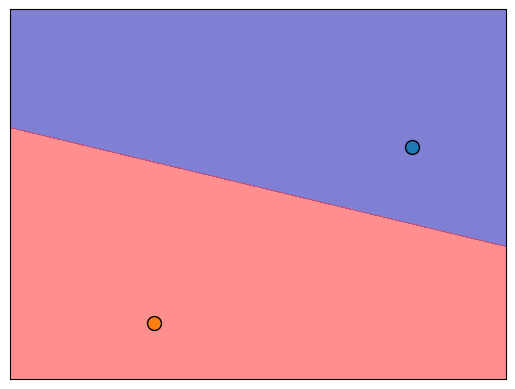

In [38]:
mglearn.discrete_scatter(
    most_confident_X[:, 0],
    most_confident_X[:, 1],
    most_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train, fill=True, eps=0.5, alpha=0.5)

The points are far away from the decision boundary which makes sense.

#### Over confident cases

Let's examine some cases where the model is confident about the prediction but the prediction is wrong.

In [39]:
np.where(X_train[:,1] > 55)  # latitudes above 55

(array([25, 55, 98]),)

In [40]:
y_train[[25, 55, 98]]

array(['Canada', 'USA', 'USA'], dtype=object)

In [41]:
over_confident_X = X_train[[55, 98]]
over_confident_X

array([[-130.0437,   55.9773],
       [-134.4197,   58.3019]])

In [42]:
over_confident_y = y_train[[55, 98]]
over_confident_y

array(['USA', 'USA'], dtype=object)

In [43]:
probs = lr.predict_proba(over_confident_X)

data_dict = {
    "y": over_confident_y,
    "y_hat": lr.predict(over_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,USA,Canada,0.932481,0.067519
1,USA,Canada,0.961898,0.038102


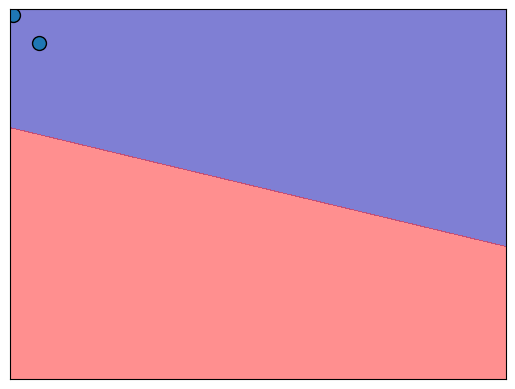

In [44]:
mglearn.discrete_scatter(
    over_confident_X[:, 0],
    over_confident_X[:, 1],
    over_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train, fill=True, eps=0.5, alpha=0.5)

- The cities are far away from the decision boundary. So the model is pretty confident about the prediction.
- But the cities are **likely to be from Alaska** and our **linear model is not able to capture that** this part belong to the USA and not Canada.

Below we are using colour to represent prediction probabilities. If you are closer to the border, the model is less confident whereas the model is more confident about the mainland cities, which makes sense.  

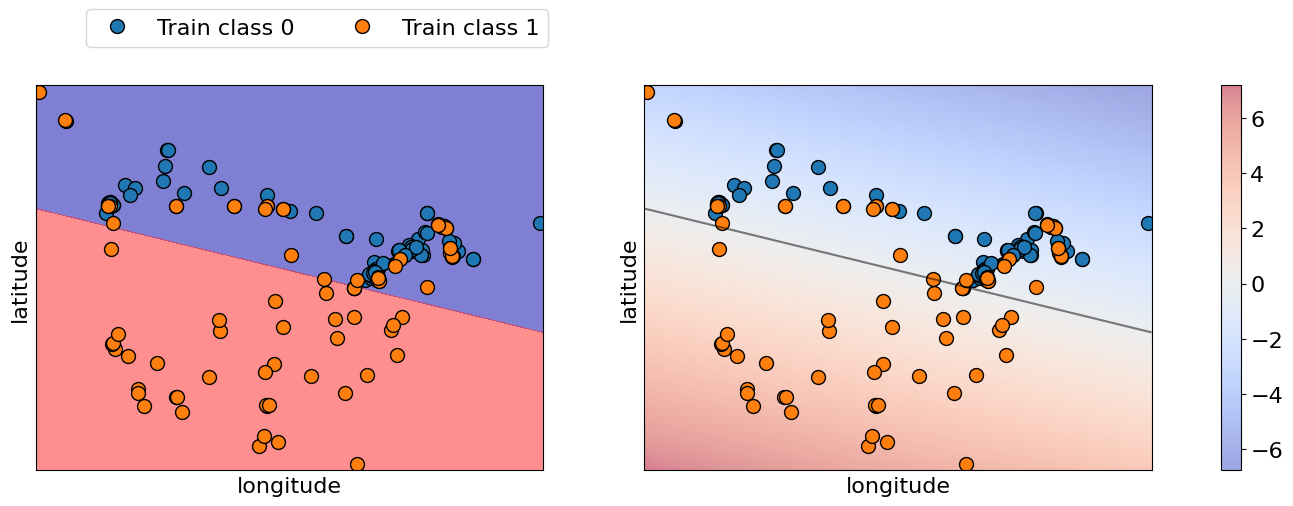

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
from matplotlib.colors import ListedColormap

for ax in axes:
    mglearn.discrete_scatter(
        X_train[:, 0], X_train[:, 1], y_train, markers="o", ax=ax
    )
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

axes[0].legend(["Train class 0", "Train class 1"], ncol=2, loc=(0.1, 1.1))

mglearn.plots.plot_2d_separator(
    lr, X_train, fill=True, eps=0.5, ax=axes[0], alpha=0.5
)
mglearn.plots.plot_2d_separator(
    lr, X_train, fill=False, eps=0.5, ax=axes[1], alpha=0.5
)
scores_image = mglearn.tools.plot_2d_scores(
    lr, X_train, eps=0.5, ax=axes[1], alpha=0.5, cm=plt.cm.coolwarm
)
cbar = plt.colorbar(scores_image, ax=axes.tolist())

Sometimes a complex model that is overfitted, tends to make more confident predictions, even if they are wrong, whereas a simpler model tends to make predictions with more uncertainty.

To summarize,
- With hard predictions, we only know the class.
- With probability scores we know how confident the model is with certain predictions, which can be useful in understanding the model better.

### Strengths of linear models

- Fast to train and predict
- Scale to large datasets and work well with sparse data
- Relatively easy to understand and interpret the predictions
- Perform well when there is a large number of features

### Limitations of linear models

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error.
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.
